# 3D Data Processing
## Lab - PointNet: Point Cloud 3D Descriptors

original paper -
[PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://web.stanford.edu/~rqi/pointnet/)


In [244]:
import numpy as np
import random
import math
import time
import copy
import os
import glob

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# pyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# a nice training progress bar
from tqdm import tqdm, trange

In [245]:
running_on_colab = False

if running_on_colab:
    # useful for visualization
    ## note: it's not necessary to restart the notebook environment after installation
    !pip install open3d

    import plotly.graph_objects as go

# visualization
import open3d as o3d


# Connect and mount your Google Drive

In [3]:
if running_on_colab:
    from google.colab import drive
    drive_path = '/content/drive'
    drive.mount(drive_path)

# General Parameters

In [246]:
if running_on_colab:
    dataset_path_train = os.path.join(drive_path, "MyDrive", "3D_dp_dataset", "3dshapes", "train")
    dataset_path_valid = os.path.join(drive_path, "MyDrive", "3D_dp_dataset", "3dshapes", "valid")
    dataset_path_test = os.path.join(drive_path,  "MyDrive", "3D_dp_dataset", "3dshapes", "test")
else:
    dataset_path_train = os.path.join("datasets", "train")
    dataset_path_valid = os.path.join("datasets", "valid")
    dataset_path_test = os.path.join("datasets", "test")

# Visualization Example
In order to visualize colored point clouds we make use of the Python package *Open3D*.

Unfortunately, the original doesn't run on Colab.
So, we replace the drawing function with a custom one (*draw_geometries*) that allows for rendering here on Colab.



In [213]:
if running_on_colab:
    def draw_geometries(geometries):
        graph_objects = []

        for geometry in geometries:
            geometry_type = geometry.get_geometry_type()

            if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
                points = np.asarray(geometry.points)
                colors = None
                if geometry.has_colors():
                    colors = np.asarray(geometry.colors)
                elif geometry.has_normals():
                    colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                else:
                    geometry.paint_uniform_color((1.0, 0.0, 0.0))
                    colors = np.asarray(geometry.colors)

                scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
                graph_objects.append(scatter_3d)

            if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
                triangles = np.asarray(geometry.triangles)
                vertices = np.asarray(geometry.vertices)
                colors = None
                if geometry.has_triangle_normals():
                    colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                    colors = tuple(map(tuple, colors))
                else:
                    colors = (1.0, 0.0, 0.0)

                mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
                graph_objects.append(mesh_3d)

        fig = go.Figure(
            data=graph_objects,
            layout=dict(
                scene=dict(
                    xaxis=dict(visible=False),
                    yaxis=dict(visible=False),
                    zaxis=dict(visible=False),
                    aspectmode='data'
                )
            )
        )
        fig.show()

In [247]:
if running_on_colab:
    o3d.visualization.draw_geometries = draw_geometries

anchor_color   = [0, 0, 1.0] # blue
positive_color = [0, 1.0, 0] # green
negative_color = [1.0, 0, 0] # red
p_colors = [anchor_color, positive_color, negative_color]

def visualize( pointcloud:np.array =None,
               anchor    :np.array =None,
               positive  :np.array =None,
               negative  :np.array =None,
               radius    :np.array =None,
               rot_mat   :np.array =None):
    """
    INPUT
      pointcloud : numpy array of 3D points
      anchor     : anchor point
      positive   :
      negative   :
    """
    geoms = []
    if pointcloud is not None:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pointcloud)
        pcd.paint_uniform_color([0.6, 0.6, 0.6])
        if rot_mat is not None:
            pcd.rotate(rot_mat, center=(0, 0, 0))
        geoms.append(pcd)
    for point, color in zip([anchor, positive, negative], p_colors):
        if point is not None:
            assert radius is not None
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=20)
            sphere.translate(point)
            sphere.paint_uniform_color(color)
            geoms.append(sphere)
    # visualize the colored point cloud
    o3d.visualization.draw_geometries(geoms)

# PointCloud Dataset



In [ ]:
from pickle import FALSE
class PointCloudData(Dataset):
    def __init__(self,
                dataset_path: str,
                samples_per_epoch: int,
                points_to_sample:int = 200000,
                radius:float =0.02,
                min_dist=1.5e-2,
                N = 750,
                noise_mean=0,
                noise_variance = 6e-5,
                is_test_set=False):
        """
          INPUT
              dataset_path: path to the dataset folder
              transform   : transform function to apply to point cloud
        """

        self.radius = radius
        self.min_dist = min_dist
        self.N = N
        self.samples_per_epoch = samples_per_epoch
        self.points_to_sample = points_to_sample
        self.noise_mean = noise_mean
        self.noise_variance = noise_variance
        self.is_test_set = is_test_set

        # _n means noised version
        self.mesh = []
        self.pcds, self.pcds_n = [], []
        self.KDtrees, self.KDtrees_n = [], []

        ## if it's the test set, pre-define a random rotation matrix
        if self.is_test_set:
            self.common_rot_mat = self.get_xyz_random_rotation()

        for file in glob.glob(dataset_path + "/*.ply"):
            print("parsing file", file)
            mesh = o3d.io.read_triangle_mesh(file)
            pcd = mesh.sample_points_uniformly(self.points_to_sample)
            if self.is_test_set:
                pcd.rotate(self.common_rot_mat.as_matrix(), center=(0, 0, 0))
            pcd_tree = o3d.geometry.KDTreeFlann(pcd)

            pcd_n = self.apply_noise(mesh.sample_points_uniformly(self.points_to_sample), self.noise_mean, self.noise_variance)
            if self.is_test_set:
                pcd_n.rotate(self.common_rot_mat.as_matrix(), center=(0, 0, 0))
            pcd_n_tree = o3d.geometry.KDTreeFlann(pcd_n)

            self.mesh.append(mesh)

            self.pcds.append(np.asarray(pcd.points))
            self.pcds_n.append(np.asarray(pcd_n.points))

            self.KDtrees.append(pcd_tree)
            self.KDtrees_n.append(pcd_n_tree)

    # function to apply noise
    def apply_noise(self, pcd, mu, sigma):
        noisy_pcd = copy.deepcopy(pcd)
        points = np.asarray(noisy_pcd.points)
        points += np.random.normal(mu, sigma, size=points.shape)
        noisy_pcd.points = o3d.utility.Vector3dVector(points)
        return noisy_pcd

    def __len__(self):
        return self.samples_per_epoch

    def get_xyz_random_rotation(self):
        random_rotation_on_xyz_axis = np.random.rand(3) * 2 * np.pi
        return R.from_euler('xyz', random_rotation_on_xyz_axis, degrees=False)

    def get_point_cloud_center(self, pc_points):
        return pc_points.mean(axis=0)

    def apply_rotation(self, point, rot_mat, pcd_center):
        return np.dot(point.reshape(1, 3), rot_mat.as_matrix().T)[0, :]

    def apply_rotation_pc(self, points, rot_mat, pcd_center):
        return np.dot(points, rot_mat.as_matrix().T)

    def bufferize_pointcloud(self, points, N):
        pc = np.zeros((self.N, 3), dtype=np.float32)
        pc[:min(self.N, points.shape[0]), :] = points[:min(self.N, points.shape[0]), :]
        return pc

    def sample_anchor_point(self, pcd_points, pcd_tree):

        anchor_pt = random.choice(pcd_points) #Extract random point from cloud points: it will be the anchor point
        num_neighbors, anchor_neighborhood_idxs, distances = pcd_tree.search_radius_vector_3d(anchor_pt, self.radius) #Find neighbors in the sphere with given radius

        return anchor_pt, anchor_neighborhood_idxs

    def sample_positive_point(self, pcd_n_points, pcd_n_tree, anchor_pt):
        _, noisy_anchor_nn_idx, _ = pcd_n_tree.search_knn_vector_3d(anchor_pt, 1) #Find correspective of anchor point in the noisy point cloud

        pos_pt = pcd_n_points[noisy_anchor_nn_idx[0]] #As said before, positive sample is set as correspective point of anchor point in the noisy point cloud
        _, noisy_positive_neighborhood_idxs, _ = pcd_n_tree.search_radius_vector_3d(pos_pt, self.radius)


        return pos_pt, noisy_positive_neighborhood_idxs

    def sample_negative_point(self, pcd_n_points, pcd_n_tree, anchor_pt):

        flag = False #Flag used to indicate whether a negative point is found or not
        neg_pt = [] #Here the found negative point will be stored
        noisy_negative_neighborhood_idxs = []

        while not flag:
          temp_negative_point = random.choice(pcd_n_points) #Extract randomly possible negative point from pcd cloud
          if np.linalg.norm(anchor_pt - temp_negative_point) > self.min_dist: #Check if random point is farther than min_dist to anchor_pt
            neg_pt = temp_negative_point      #If yes save it as actual neg_pt
            _, noisy_negative_neighborhood_idxs, _ = pcd_n_tree.search_radius_vector_3d(neg_pt, self.radius) #Find neg neighborhood
            flag = True #We found the point, so we exit the loop

        return neg_pt, noisy_negative_neighborhood_idxs

    def get_sampled_pointcloud(self, mesh_idx, N):
        idxs = np.arange(0, self.pcds[mesh_idx].shape[0], 1)
        np.random.shuffle(idxs)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(self.pcds[mesh_idx][idxs[:N]])
        return pcd

    def generate_test_set(self, mesh_idx, N=500):

        self.test_points = self.pcds[mesh_idx]

        ## sample test points randomly
        idxs = np.arange(0, self.test_points.shape[0], 1)
        np.random.shuffle(idxs)
        self.test_points_sampled = self.test_points[idxs[:N]]


        self.test_tree = self.KDtrees[mesh_idx]

    def generate_noisy_test_set(self, mesh_idx):
        self.test_points_n = self.pcds_n[mesh_idx]
        self.test_tree_n = self.KDtrees_n[mesh_idx]

        test_points_sampled_n = []
        for i in tqdm(range(self.test_points_sampled.shape[0])):
            _, gt_nn_idx, _ = self.test_tree_n.search_knn_vector_3d(self.test_points_sampled[i], 1)
            gt_nearest_point = self.test_points_n[gt_nn_idx].squeeze()
            test_points_sampled_n.append(gt_nearest_point)

        self.test_points_sampled_n = np.asarray(test_points_sampled_n)

    def compute_descriptors(self, tinypointnet, noisy=False):
        tinypointnet.eval()

        if noisy:
            queries = self.test_points_sampled_n
            tree    = self.test_tree_n
            points  = self.test_points_n
        else:
            queries = self.test_points_sampled
            tree    = self.test_tree
            points  = self.test_points
        tot_queries = queries.shape[0]

        descriptors = np.zeros((tot_queries, 256), dtype=np.float32)
        for i in tqdm(range(tot_queries)):
            pt = queries[i]

            ## find neighborhood of points
            _, idx, _ = tree.search_radius_vector_3d(pt, self.radius)
            point_set = points[idx]

            ## normalize the points
            point_set = (point_set - pt)

            pc = np.zeros((self.N, 3), dtype=np.float32)
            pc[:min(self.N, point_set.shape[0]), :] = point_set[:min(self.N, point_set.shape[0]), :]

            # transform
            anchor  = torch.from_numpy(pc).unsqueeze(0).float().transpose(1,2).to(device)
            descriptors[i, :] = tinypointnet(anchor)[0, :, 0].cpu().detach().numpy()
        return descriptors

    def __getitem__(self, _):
        mesh_idx = np.random.randint(0, len(self.mesh))

        pcd_points = self.pcds[mesh_idx]        ## anchor will be drawn from this
        pcd_n_points = self.pcds_n[mesh_idx]    ## positive and negative will be drawn from this

        # ANCHOR: select a random anchor point
        anchor_pt, anchor_neighborhood_idxs = self.sample_anchor_point(pcd_points, self.KDtrees[mesh_idx])

        # POSITIVE: find corresponding point in the noisy point cloud
        pos_pt, noisy_positive_neighborhood_idxs = self.sample_positive_point(pcd_n_points, self.KDtrees_n[mesh_idx], anchor_pt)

        # NEGATIVE: find far point (at least at distance min_dist)
        neg_pt, noisy_negative_neighborhood_idxs = self.sample_negative_point(pcd_n_points, self.KDtrees_n[mesh_idx], anchor_pt)
        if neg_pt is None: ## it should never fail, but if it fails: restart experiment
            quit("FAIL: restart experiment")


        # get points
        point_set_anchor   = pcd_points[anchor_neighborhood_idxs]
        point_set_positive = pcd_n_points[noisy_positive_neighborhood_idxs]
        point_set_negative = pcd_n_points[noisy_negative_neighborhood_idxs]

        if not self.is_test_set:
            # generate a random rotation
            rot_mat = self.get_xyz_random_rotation()

            # apply the random rotation to point cloud and points
            pcd_points_center = self.get_point_cloud_center(pcd_points)
            pcd_n_points_center = self.get_point_cloud_center(pcd_n_points)
            anchor_pt = self.apply_rotation(anchor_pt, rot_mat, pcd_points_center)
            pos_pt    = self.apply_rotation(pos_pt, rot_mat, pcd_n_points_center)
            neg_pt    = self.apply_rotation(neg_pt, rot_mat, pcd_n_points_center)
            point_set_anchor   = self.apply_rotation_pc(point_set_anchor, rot_mat, pcd_points_center)
            point_set_positive = self.apply_rotation_pc(point_set_positive, rot_mat, pcd_n_points_center)
            point_set_negative = self.apply_rotation_pc(point_set_negative, rot_mat, pcd_n_points_center)
        else:
            rot_mat = self.common_rot_mat

        # center points around their centroid
        point_set_anchor   = (point_set_anchor - anchor_pt)
        point_set_positive = (point_set_positive - pos_pt)
        point_set_negative = (point_set_negative - neg_pt)

        # copy points coordinates to a fixed dimension np.array
        point_set_anchor   = self.bufferize_pointcloud(point_set_anchor  , self.N)
        point_set_positive = self.bufferize_pointcloud(point_set_positive, self.N)
        point_set_negative = self.bufferize_pointcloud(point_set_negative, self.N)

        # transform from numpy to torch.Tensor
        point_set_anchor    = torch.from_numpy(point_set_anchor)
        point_set_positive  = torch.from_numpy(point_set_positive)
        point_set_negative  = torch.from_numpy(point_set_negative)

        return mesh_idx, point_set_anchor, point_set_positive, point_set_negative, anchor_pt, pos_pt, neg_pt, rot_mat.as_matrix()


# Dataset Creation

Now we can instantiate our training and test dataset objects.

In [408]:
train_ds  = PointCloudData(dataset_path_train, samples_per_epoch=500)
valid_ds  = PointCloudData(dataset_path_valid, samples_per_epoch=500)
test_ds   = PointCloudData(dataset_path_test,  samples_per_epoch=500, is_test_set=True)

parsing file datasets\train\Armadillo.ply
parsing file datasets\train\bun_zipper.ply
parsing file datasets\train\dragon_vrip.ply
parsing file datasets\valid\Armadillo.ply
parsing file datasets\valid\bun_zipper.ply
parsing file datasets\valid\dragon_vrip.ply
parsing file datasets\test\happy_vrip.ply


Creating a `Dataset` class may seem unnecessary for the most basic problems. But it really helps when the dataset and the training procedure start to get more complex.

One of the most useful benefit of defining a `Dataset` class is the possiblity to use the PyTorch `Dataloader` module.

By operating on the dataset directly, we are losing out on a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear.

In [409]:
# warning: batch_size needs to be at least 2
train_loader  = DataLoader( dataset=train_ds,  batch_size=50, shuffle=True  )
valid_loader  = DataLoader( dataset=valid_ds,  batch_size=50, shuffle=False )
test_loader   = DataLoader( dataset=test_ds,   batch_size=20, shuffle=False )

# Visualize some data

In [410]:
ds = train_ds

for (mesh_idx, _, _, _, anchor, positive, negative, rot_mat) in ds:
    idx = mesh_idx
    visualize(ds.pcds[idx],
              anchor = anchor,
              positive = positive,
              negative = negative,
              radius=ds.radius,
              rot_mat=rot_mat)
    break


# Network Definition

## Network Base Module


In [411]:
# Multi Layer Perceptron
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size   = input_size
        self.output_size  = output_size
        self.conv  = nn.Conv1d(self.input_size, self.output_size, 1)
        self.bn    = nn.BatchNorm1d(self.output_size)

    def forward(self, input):
        return F.relu(self.bn(self.conv(input)))

# Fully Connected with Batch Normalization
class FC_BN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size   = input_size
        self.output_size  = output_size
        self.lin  = nn.Linear(self.input_size, self.output_size)
        self.bn    = nn.BatchNorm1d(self.output_size)

    def forward(self, input):
        return F.relu(self.bn(self.lin(input)))

class TNet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k

        self.mlp1 = MLP(self.k, 64)
        self.mlp2 = MLP(64, 128)
        self.mlp3 = MLP(128, 1024)

        self.fc_bn1 = FC_BN(1024, 512)
        self.fc_bn2 = FC_BN(512,256)

        self.fc3 = nn.Linear(256,k*k)


    def forward(self, input):
        # input.shape == (batch_size,n,3)

        bs = input.size(0)
        xb = self.mlp1(input)
        xb = self.mlp2(xb)
        xb = self.mlp3(xb)

        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)

        xb = self.fc_bn1(flat)
        xb = self.fc_bn2(xb)

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

In [ ]:
class TinyPointNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform   = TNet(k=3) ## if you use the shot rotation matrix, this is not going to be used
        self.feature_transform = TNet(k=64)

        #Layers of First MLP
        self.mlp_A_1 = MLP(3, 64) #Input size 3, output size 64
        self.mlp_A_2 = MLP(64,64) #Input size 64, output size 64

        #Layers of Second MLP
        self.mlp_B_1 = MLP(64, 64) #Input size 64, output size 64
        self.mlp_B_2 = MLP(64,128) #Input size 64, output size 128
        self.mlp_B_3 = MLP(128,256) #Input size 128, output size 256

    def forward(self, input):
        #input.size = [50, 3, 750]
        #print(input.size()) #PROVA
        n_pts = input.size()[2] #750
        matrix3x3 = self.input_transform(input)
        #matrix3x3 = self.shot_canonical_rotation(input, 3)
        input_transform_output = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2) #Output of size [50, 3, 750]


        #Apply first MLP
        x = self.mlp_A_1(input_transform_output) # 3 as input, 64 as output  -> [50, 64, 750]
        x = self.mlp_A_2(x) #Apply the second layer -> from 64 to 64 [50, 64, 750]

        matrix64x64 = self.feature_transform(x) #Obtain 64x64 matrix applying TNet to output of first MLP
        x = torch.bmm(torch.transpose(x, 1, 2), matrix64x64).transpose(1,2) #Multiply the 64x64 with the output of MLP -> output size: [50, 64, 750]

        #Apply second MLP
        x = self.mlp_B_1(x) # First layer, output size: [50, 64, 750]
        x = self.mlp_B_2(x) # Second layer, output size: [50, 128, 750]
        x = self.mlp_B_3(x) # Third layer, output size: [50, 256, 750]

        #Max Pooling stage
        x = nn.MaxPool1d(x.size(-1))(x) #In the end we have a vector of size [50, 256, 1] (which is the descriptor)

        return x

    
    def shot_canonical_rotation(self, input, k):
        # input.shape == (batch_size, k, n)
        batch_size, _, n = input.size() 
        rotation_matrices = []

        for i in range(batch_size):
            features_batch = input[i]
            centroid = torch.mean(features_batch, dim=1, keepdim=True)
            centered_features = features_batch - centroid

            if torch.any(torch.isnan(centered_features)) or torch.any(torch.isinf(centered_features)):
                centered_features[torch.isnan(centered_features) | torch.isinf(centered_features)] = 1e-6

            distances = torch.norm(centered_features, dim=0)

            weights = 1.0 - distances
            weights[weights < 0] = 0

            weights_sum = torch.sum(weights)
            if weights_sum > 0:
                weights = weights / weights_sum
            else:
                weights = torch.ones_like(weights) / n

            weighted_cov_matrix = torch.zeros((centered_features.size(0), centered_features.size(0)), device=input.device)

          
            v = centered_features  #Get the centered features
            weighted_cov_matrix = torch.einsum('n,in,jn->ij', weights, v, v) #Calculate the Covariance Matrix


            weighted_cov_matrix += torch.eye(weighted_cov_matrix.size(-1), device=input.device) * 1e-6


            eigvals, eigvecs = torch.linalg.eigh(weighted_cov_matrix) #Get eigenvalues and eigenvectors of the covariance matrix
            idx = torch.argsort(eigvals, descending=True) #Get index of the sorting in descending order
            V = eigvecs[:, idx] #Sort and save eigenvectors

            rotation_matrix = V[:, :k]

            for j in range(k):
                signs = torch.sign(torch.sum(centered_features * rotation_matrix[:, j].unsqueeze(1), dim=0))
                if torch.sum(signs >= 0) < torch.sum(signs < 0):
                    rotation_matrix[:, j] = -rotation_matrix[:, j]

            rotation_matrices.append(rotation_matrix)

        return torch.stack(rotation_matrices, dim=0)


## Visualize the Training trend

# Training loop

In [444]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [445]:
tinypointnet = TinyPointNet()
tinypointnet.to(device);

In [446]:
optimizer = torch.optim.Adam(tinypointnet.parameters(), lr=0.0005)


In [ ]:
def soft_triplet_loss(anchor, positive, negative, alpha=10.0):

    d_pos = F.pairwise_distance(anchor, positive)
    d_neg = F.pairwise_distance(anchor, negative)
    loss = F.softplus(alpha * (d_pos - d_neg)) #Used softplus instead of exp in order to mitigate numerical issues

    return loss.mean()


#Function created to confront soft and standard triplet loss
def triplet_loss(anchor, positive, negative, margin=0.2):
    d_pos = F.pairwise_distance(anchor, positive)
    d_neg = F.pairwise_distance(anchor, negative)
    loss = F.relu(d_pos - d_neg + margin)
    return loss.mean()


def train(model, train_loader, valid_loader=None,  epochs=45, save=True):
    best_valid_loss = 1e10

    tinypointnetloss = triplet_loss

    # these lists keep track of the losses across epochs
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        # local list of losses
        train_loss, valid_loss = [], []

        # train
        tinypointnet.train()

        for (_, anchor, positive, negative, _, _, _, _) in tqdm(train_loader):

            # retrieve anchors, positives and negatives batch
            anchor   =   anchor.to(device).float().transpose(1,2)
            positive = positive.to(device).float().transpose(1,2)
            negative = negative.to(device).float().transpose(1,2)

            optimizer.zero_grad()

            # let PointNetTiny model compute the descriptors
            anchor_desc   = tinypointnet(anchor)
            positive_desc = tinypointnet(positive)
            negative_desc = tinypointnet(negative)

            # compute the loss associated to these descriptors
            loss = tinypointnetloss(anchor_desc, positive_desc, negative_desc)


            # Backpropagate the gradient
            loss.backward()
            optimizer.step()

            # Keep track of the statistics
            train_loss.append(loss.item())
            #pbar.set_postfix(loss=curr_loss)

        train_loss = np.asarray(train_loss).mean()
        print(f'epoch {epoch} - train loss:', train_loss)
        train_losses.append(train_loss)

        # validation
        tinypointnet.eval()
        pbar = tqdm(valid_loader, leave=False)

        with torch.no_grad():
            for (_, anchor, positive, negative, _, _, _, _) in pbar:
                pbar.set_description(f"valid - epoch {epoch}")

                anchor   =   anchor.to(device).float().transpose(1,2)
                positive = positive.to(device).float().transpose(1,2)
                negative = negative.to(device).float().transpose(1,2)

                anchor_desc   = tinypointnet(anchor)
                positive_desc = tinypointnet(positive)
                negative_desc = tinypointnet(negative)
                loss = tinypointnetloss(anchor_desc, positive_desc, negative_desc)
                curr_loss = loss.item()

                valid_loss.append(curr_loss)

                pbar.set_postfix(loss=curr_loss)

        valid_loss = np.asarray(valid_loss).mean()
        print(f'epoch {epoch} - valid loss:', valid_loss)
        valid_losses.append(valid_loss)

        # save the model
        if save and valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            if running_on_colab:
                path = os.path.join(drive_path, "MyDrive", "tinypointnetmodel.yml")
            else:
                path = os.path.join("tinypointnetmodel.yml")
            print("best_valid_loss:", best_valid_loss, "saving model at", path)
            torch.save(tinypointnet.state_dict(), path)
    return train_losses, valid_losses


In [448]:
train_losses, valid_losses = train(tinypointnet, train_loader, valid_loader, save=True)

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


epoch 0 - train loss: 0.1462111622095108


epoch 0 - valid loss: 0.1972211331129074
best_valid_loss: 0.1972211331129074 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


epoch 1 - train loss: 0.07628924809396267


epoch 1 - valid loss: 0.16945936232805253
best_valid_loss: 0.16945936232805253 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 2 - train loss: 0.08174317143857479


epoch 2 - valid loss: 0.11313856542110443
best_valid_loss: 0.11313856542110443 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


epoch 3 - train loss: 0.06338137648999691


epoch 3 - valid loss: 0.06368672177195549
best_valid_loss: 0.06368672177195549 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


epoch 4 - train loss: 0.055961912497878075


epoch 4 - valid loss: 0.05131414420902729
best_valid_loss: 0.05131414420902729 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


epoch 5 - train loss: 0.04806723892688751


epoch 5 - valid loss: 0.04264948628842831
best_valid_loss: 0.04264948628842831 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


epoch 6 - train loss: 0.04118626043200493


epoch 6 - valid loss: 0.043552757054567334


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


epoch 7 - train loss: 0.04080293606966734


epoch 7 - valid loss: 0.04317463953047991


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 8 - train loss: 0.038720283471047875


epoch 8 - valid loss: 0.04039095230400562
best_valid_loss: 0.04039095230400562 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 9 - train loss: 0.03470576535910368


epoch 9 - valid loss: 0.041612234339118


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


epoch 10 - train loss: 0.045617389306426046


epoch 10 - valid loss: 0.051927723363041876


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 11 - train loss: 0.03891246598213911


epoch 11 - valid loss: 0.04181317966431379


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 12 - train loss: 0.041148601844906804


epoch 12 - valid loss: 0.034384478069841865
best_valid_loss: 0.034384478069841865 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


epoch 13 - train loss: 0.03865549862384796


epoch 13 - valid loss: 0.039001892879605295


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


epoch 14 - train loss: 0.038394460640847686


epoch 14 - valid loss: 0.03663234356790781


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


epoch 15 - train loss: 0.033594397269189356


epoch 15 - valid loss: 0.03962493222206831


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


epoch 16 - train loss: 0.03596176281571388


epoch 16 - valid loss: 0.054106094501912595


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 17 - train loss: 0.04603737760335207


epoch 17 - valid loss: 0.034024260006845
best_valid_loss: 0.034024260006845 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


epoch 18 - train loss: 0.04360822141170502


epoch 18 - valid loss: 0.0348459092900157


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


epoch 19 - train loss: 0.03161833100020885


epoch 19 - valid loss: 0.0344302293844521


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


epoch 20 - train loss: 0.029761139675974844


epoch 20 - valid loss: 0.034844227507710455


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


epoch 21 - train loss: 0.032064218260347846


epoch 21 - valid loss: 0.03602821435779333


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


epoch 22 - train loss: 0.04229253381490707


epoch 22 - valid loss: 0.03443369530141353


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 23 - train loss: 0.032816763035953045


epoch 23 - valid loss: 0.035093572735786435


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 24 - train loss: 0.0303609611466527


epoch 24 - valid loss: 0.03288578316569328
best_valid_loss: 0.03288578316569328 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


epoch 25 - train loss: 0.02858935482800007


epoch 25 - valid loss: 0.02770333467051387
best_valid_loss: 0.02770333467051387 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


epoch 26 - train loss: 0.03137803040444851


epoch 26 - valid loss: 0.03721772413700819


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


epoch 27 - train loss: 0.03670536689460278


epoch 27 - valid loss: 0.03357244748622179


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


epoch 28 - train loss: 0.03063966576009989


epoch 28 - valid loss: 0.03052989486604929


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


epoch 29 - train loss: 0.033269422687590124


epoch 29 - valid loss: 0.031482355669140816


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 30 - train loss: 0.03853810783475638


epoch 30 - valid loss: 0.03634121511131525


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 31 - train loss: 0.038370067812502386


epoch 31 - valid loss: 0.03079593200236559


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 32 - train loss: 0.03175950031727552


epoch 32 - valid loss: 0.03566068075597286


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 33 - train loss: 0.04059548880904913


epoch 33 - valid loss: 0.03524034284055233


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 34 - train loss: 0.02914684936404228


epoch 34 - valid loss: 0.03286454789340496


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 35 - train loss: 0.030393134988844394


epoch 35 - valid loss: 0.03315519681200385


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 36 - train loss: 0.0201140278019011


epoch 36 - valid loss: 0.03274307129904628


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 37 - train loss: 0.029754087142646313


epoch 37 - valid loss: 0.025131912110373376
best_valid_loss: 0.025131912110373376 saving model at tinypointnetmodel.yml


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 38 - train loss: 0.024302237760275604


epoch 38 - valid loss: 0.02644062079489231


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 39 - train loss: 0.029420026298612355


epoch 39 - valid loss: 0.026572028640657663


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 40 - train loss: 0.02816280918195844


epoch 40 - valid loss: 0.027295669447630642


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 41 - train loss: 0.028026136569678783


epoch 41 - valid loss: 0.030118997767567636


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


epoch 42 - train loss: 0.02820960097014904


epoch 42 - valid loss: 0.03138926737010479


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


epoch 43 - train loss: 0.024287460930645467


epoch 43 - valid loss: 0.03537134937942028


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


epoch 44 - train loss: 0.02508307797834277


epoch 44 - valid loss: 0.031094895862042903


## Visualize the Training trend

In [449]:
def numpy_ewma_vectorized_v2(data, window=10):
    # Return the Exponentially Weighted Moving Average
    # for better visualizing the "trend" of the metrics

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

### Plot the trend of train and valid losses
By using an Exponentially Weighted Moving Average of the losses,
we can better understand the behaviour of our network by filtering out
the noisy *local values* and focusing more on the *global trend*.

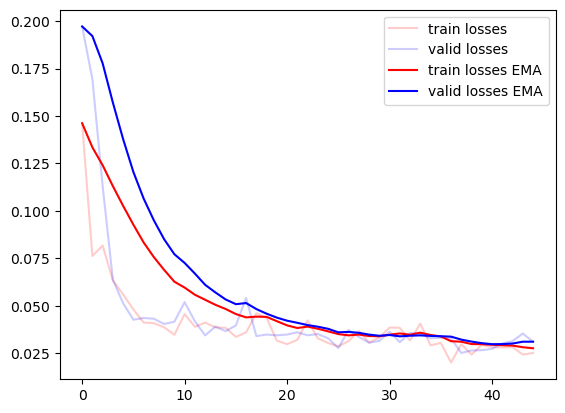

In [450]:
plt.plot(train_losses, label="train losses", color='r', alpha=0.2)
plt.plot(valid_losses, label="valid losses", color='b', alpha=0.2)
plt.plot(numpy_ewma_vectorized_v2(np.array(train_losses)), label="train losses EMA", color='r')
plt.plot(numpy_ewma_vectorized_v2(np.array(valid_losses)), label="valid losses EMA", color='b')
plt.legend()

# Test: feature matching

Let's compute the model test metrics

> First we need to load the best model weights





## Load checkpoint

In [451]:
if running_on_colab:
    path = os.path.join(drive_path, "MyDrive", "tinypointnetmodel.yml")
else:
    path = os.path.join("tinypointnetmodel.yml")
tinypointnet = TinyPointNet()
tinypointnet.load_state_dict(torch.load(path))
tinypointnet.to(device)

C:\Users\Juri\AppData\Local\Temp\ipykernel_15092\277679717.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tinypointnet.load_state_dict(torch.load(path))


TinyPointNet(
  (input_transform): TNet(
    (mlp1): MLP(
      (conv): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp2): MLP(
      (conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (mlp3): MLP(
      (conv): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc_bn1): FC_BN(
      (lin): Linear(in_features=1024, out_features=512, bias=True)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc_bn2): FC_BN(
      (lin): Linear(in_features=512, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fc3): Linear(in_features=256, out_features=9, bias

## Prepare the test set

In [422]:
test_ds.generate_test_set(0, 2000)

## build the ground truth nearest neighbors
## in other words, find thepoints in the noisy test points
## that are the nearest neighbors to the original, sampled, test points
test_ds.generate_noisy_test_set(0)


100%|██████████| 2000/2000 [00:00<00:00, 94689.17it/s]


### Visualize the sampled test points
Little red spheres represent the test points sampled from the original test mesh

In [452]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(test_ds.test_points_sampled_n)
pcd.paint_uniform_color([0.5, 0.5, 0.5])
geoms = [pcd]

# visualize the colored point cloud
o3d.visualization.draw_geometries(geoms)

In [453]:
pcd = test_ds.get_sampled_pointcloud(mesh_idx=0, N=5000)
pcd.paint_uniform_color([0.5, 0.5, 0.5])
geoms = [pcd]
for point in test_ds.test_points_sampled_n:
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1e-3)
    sphere.translate(point)
    sphere.paint_uniform_color([1, 0, 0])
    geoms.append(sphere)

# visualize the colored point cloud
o3d.visualization.draw_geometries(geoms)


### Compute the descriptor of each point in each point set

In [454]:
descs   = test_ds.compute_descriptors(tinypointnet)
descs_n = test_ds.compute_descriptors(tinypointnet, noisy=True)

100%|██████████| 2000/2000 [00:13<00:00, 149.38it/s]


## Matching time
In other words, get the descriptor from the noisy point cloud which is closest to the query descriptor from the original point cloud

In [455]:
pcd = test_ds.get_sampled_pointcloud(mesh_idx=0, N=5000)
pcd.paint_uniform_color([0.5, 0.5, 0.5])
geoms = [pcd]
for row in tqdm(range(test_ds.test_points_sampled_n.shape[0])):
    anchor       = test_ds.test_points_sampled[row]
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1e-3)
    sphere.translate(anchor)
    sphere.paint_uniform_color([1, 0, 0])
    geoms.append(sphere)


o3d.visualization.draw_geometries(geoms)


100%|██████████| 2000/2000 [00:00<00:00, 23313.60it/s]


In [456]:
correct = tot = 0

for row in tqdm(range(test_ds.test_points_sampled.shape[0])):
    desc = descs[row, :]
    dists = []
    anchor       = test_ds.test_points_sampled[row]
    true_near_pt = test_ds.test_points_sampled_n[row]

    for row2 in range(test_ds.test_points_sampled_n.shape[0]):
        desc2 = descs_n[row2, :]
        dist = np.linalg.norm(desc - desc2)
        dists.append(dist)

    min_row = np.argmin(np.asarray(dists))

    pred_pt = test_ds.test_points_sampled_n[min_row].squeeze()

    dist = np.linalg.norm(true_near_pt - pred_pt)

    #visualize(test_ds.test_points_sampled,
    #           anchor = anchor,
     #          positive = pred_pt,
      #        radius=test_ds.radius)

    if dist<test_ds.radius:
        correct += 1
    tot += 1

print()
print(f"accuracy: {correct*100/tot:6.3f}%")



100%|██████████| 2000/2000 [00:14<00:00, 137.08it/s]


accuracy: 65.450%
